In [1]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("data.csv", encoding="ISO-8859-1")

In [3]:
data

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...
...,...,...,...
99984,99996,0,@Cupcake seems like a repeating problem hop...
99985,99997,1,@cupcake__ arrrr we both replied to each other...
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


In [4]:
with open('contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

In [5]:
contractions

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

###### Setting Pandas DataFrame to show non-truncated table

In [6]:
pd.set_option('display.max_colwidth', -1)

C:\Users\91620\AppData\Local\Temp\ipykernel_16224\3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


##### Printing the dataset

In [7]:
data.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


##### Taking column names into variables

In [8]:
tweet = data.columns.values[2]
sentiment = data.columns.values[1]
tweet, sentiment

('SentimentText', 'Sentiment')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99989 entries, 0 to 99988
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ItemID         99989 non-null  int64 
 1   Sentiment      99989 non-null  int64 
 2   SentimentText  99989 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [10]:
data

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T
...,...,...,...
99984,99996,0,@Cupcake seems like a repeating problem hope you're able to find something.
99985,99997,1,"@cupcake__ arrrr we both replied to each other over different tweets at the same time , i'll see you then, Duno where the hell Kateyy is!"
99986,99998,0,@CuPcAkE_2120 ya i thought so
99987,99999,1,@Cupcake_Dollie Yes. Yes. I'm glad you had more fun with me.


In [11]:
data.duplicated().sum()

0

In [12]:
data.isnull().sum()

ItemID           0
Sentiment        0
SentimentText    0
dtype: int64

<br/>

# 1)  Preprocessing

* **Convert every tweets to lower case**
* **Remove Twitter username**
* **Remove punctuations, numbers and special characters**
* **Convert more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Remove extra spaces**
* **Remove URLs**
* **Emoji analysis**
* **Handle contractions words**
    - **" can't " >> " can not "**
    - **" won't " >> " will not "**
    - **" should't " >> " should not "**
* **Tokenization**
* **(Optional) Remove [Stop words](https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)**

##### handle emoji

In [13]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


###### preprocess the tweets

In [14]:
import re

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet

In [15]:
data['processed_tweet'] = np.vectorize(process_tweet)(data[tweet])

###### Let's compare unprocessed tweets with the processed one

In [16]:
data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


### Spelling correction

### Tokenization

In [17]:
tokenized_tweet = data['processed_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [is, so, sad, for, my, apl, friend]                                                                                 
1    [missed, the, new, moon, trailer]                                                                                   
2    [omg, its, already]                                                                                                 
3    [omgaga, im, soo, im, gunna, cry, ve, been, at, this, dentist, since, was, suposed, just, get, crown, put, on, mins]
4    [think, mi, bf, is, cheating, on, me, t_t]                                                                          
Name: processed_tweet, dtype: object

### Lemmatization

In [18]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
tokenized_tweet.head()

0    [is, so, sad, for, my, apl, friend]                                                                               
1    [missed, the, new, moon, trailer]                                                                                 
2    [omg, it, already]                                                                                                
3    [omgaga, im, soo, im, gunna, cry, ve, been, at, this, dentist, since, wa, suposed, just, get, crown, put, on, min]
4    [think, mi, bf, is, cheating, on, me, t_t]                                                                        
Name: processed_tweet, dtype: object

# 2) Most used words

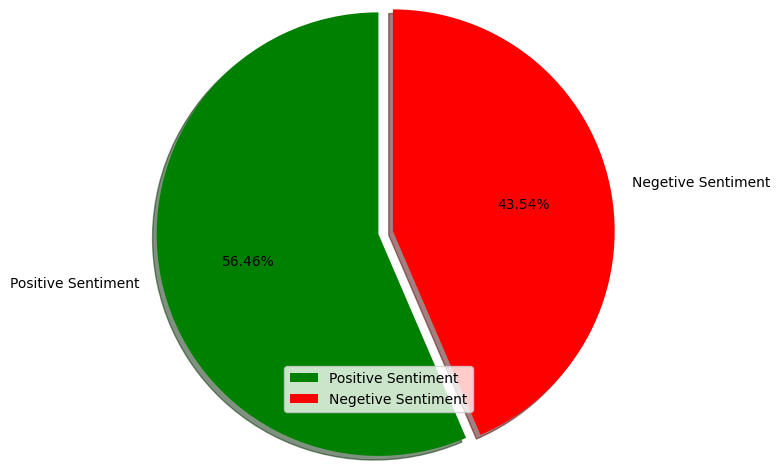

In [19]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
slices = [(data[sentiment] != 0).sum(), (data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## 2.2) Most used positive words

<Figure size 3840x2880 with 0 Axes>

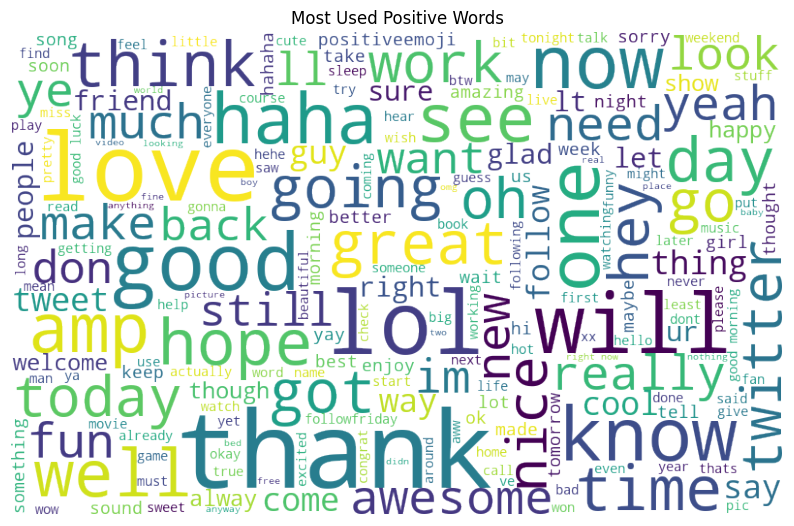

In [20]:
positive_words =' '.join([text for text in data['processed_tweet'][data[sentiment] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
plt.show()

## 2.3) Most used negetive words

<Figure size 3840x2880 with 0 Axes>

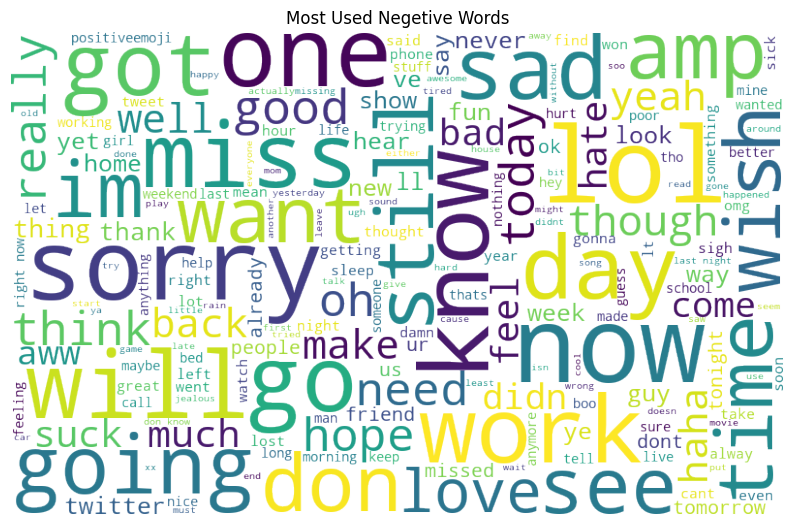

In [21]:
negetive_words =' '.join([text for text in data['processed_tweet'][data[sentiment] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, 
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negetive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negetive Words")
plt.show()

#### See the word `lol`. It is used both in positive and negetive(sarcastic) sentiments. We still can't classify sarcasm.

# 3) Feature extraction (vectorization)

## 3.1) Count vectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1, 2))  # Unigram and Bigram
final_vectorized_data = count_vectorizer.fit_transform(data['processed_tweet'])


In [23]:
final_vectorized_data

<99989x455478 sparse matrix of type '<class 'numpy.int64'>'
	with 2112514 stored elements in Compressed Sparse Row format>

# 4) Splitting

##### Splitting train data to test accuracy

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, data[sentiment],
                                                    test_size=0.2, random_state=69)  

##### Printing splitted dataset sizes

In [25]:
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (79991, 455478)
X_test_shape :  (19998, 455478)
y_train_shape :  (79991,)
y_test_shape :  (19998,)


# 5) Train and predict

## 5.1) Naive_bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

##### Print Confusion matrix

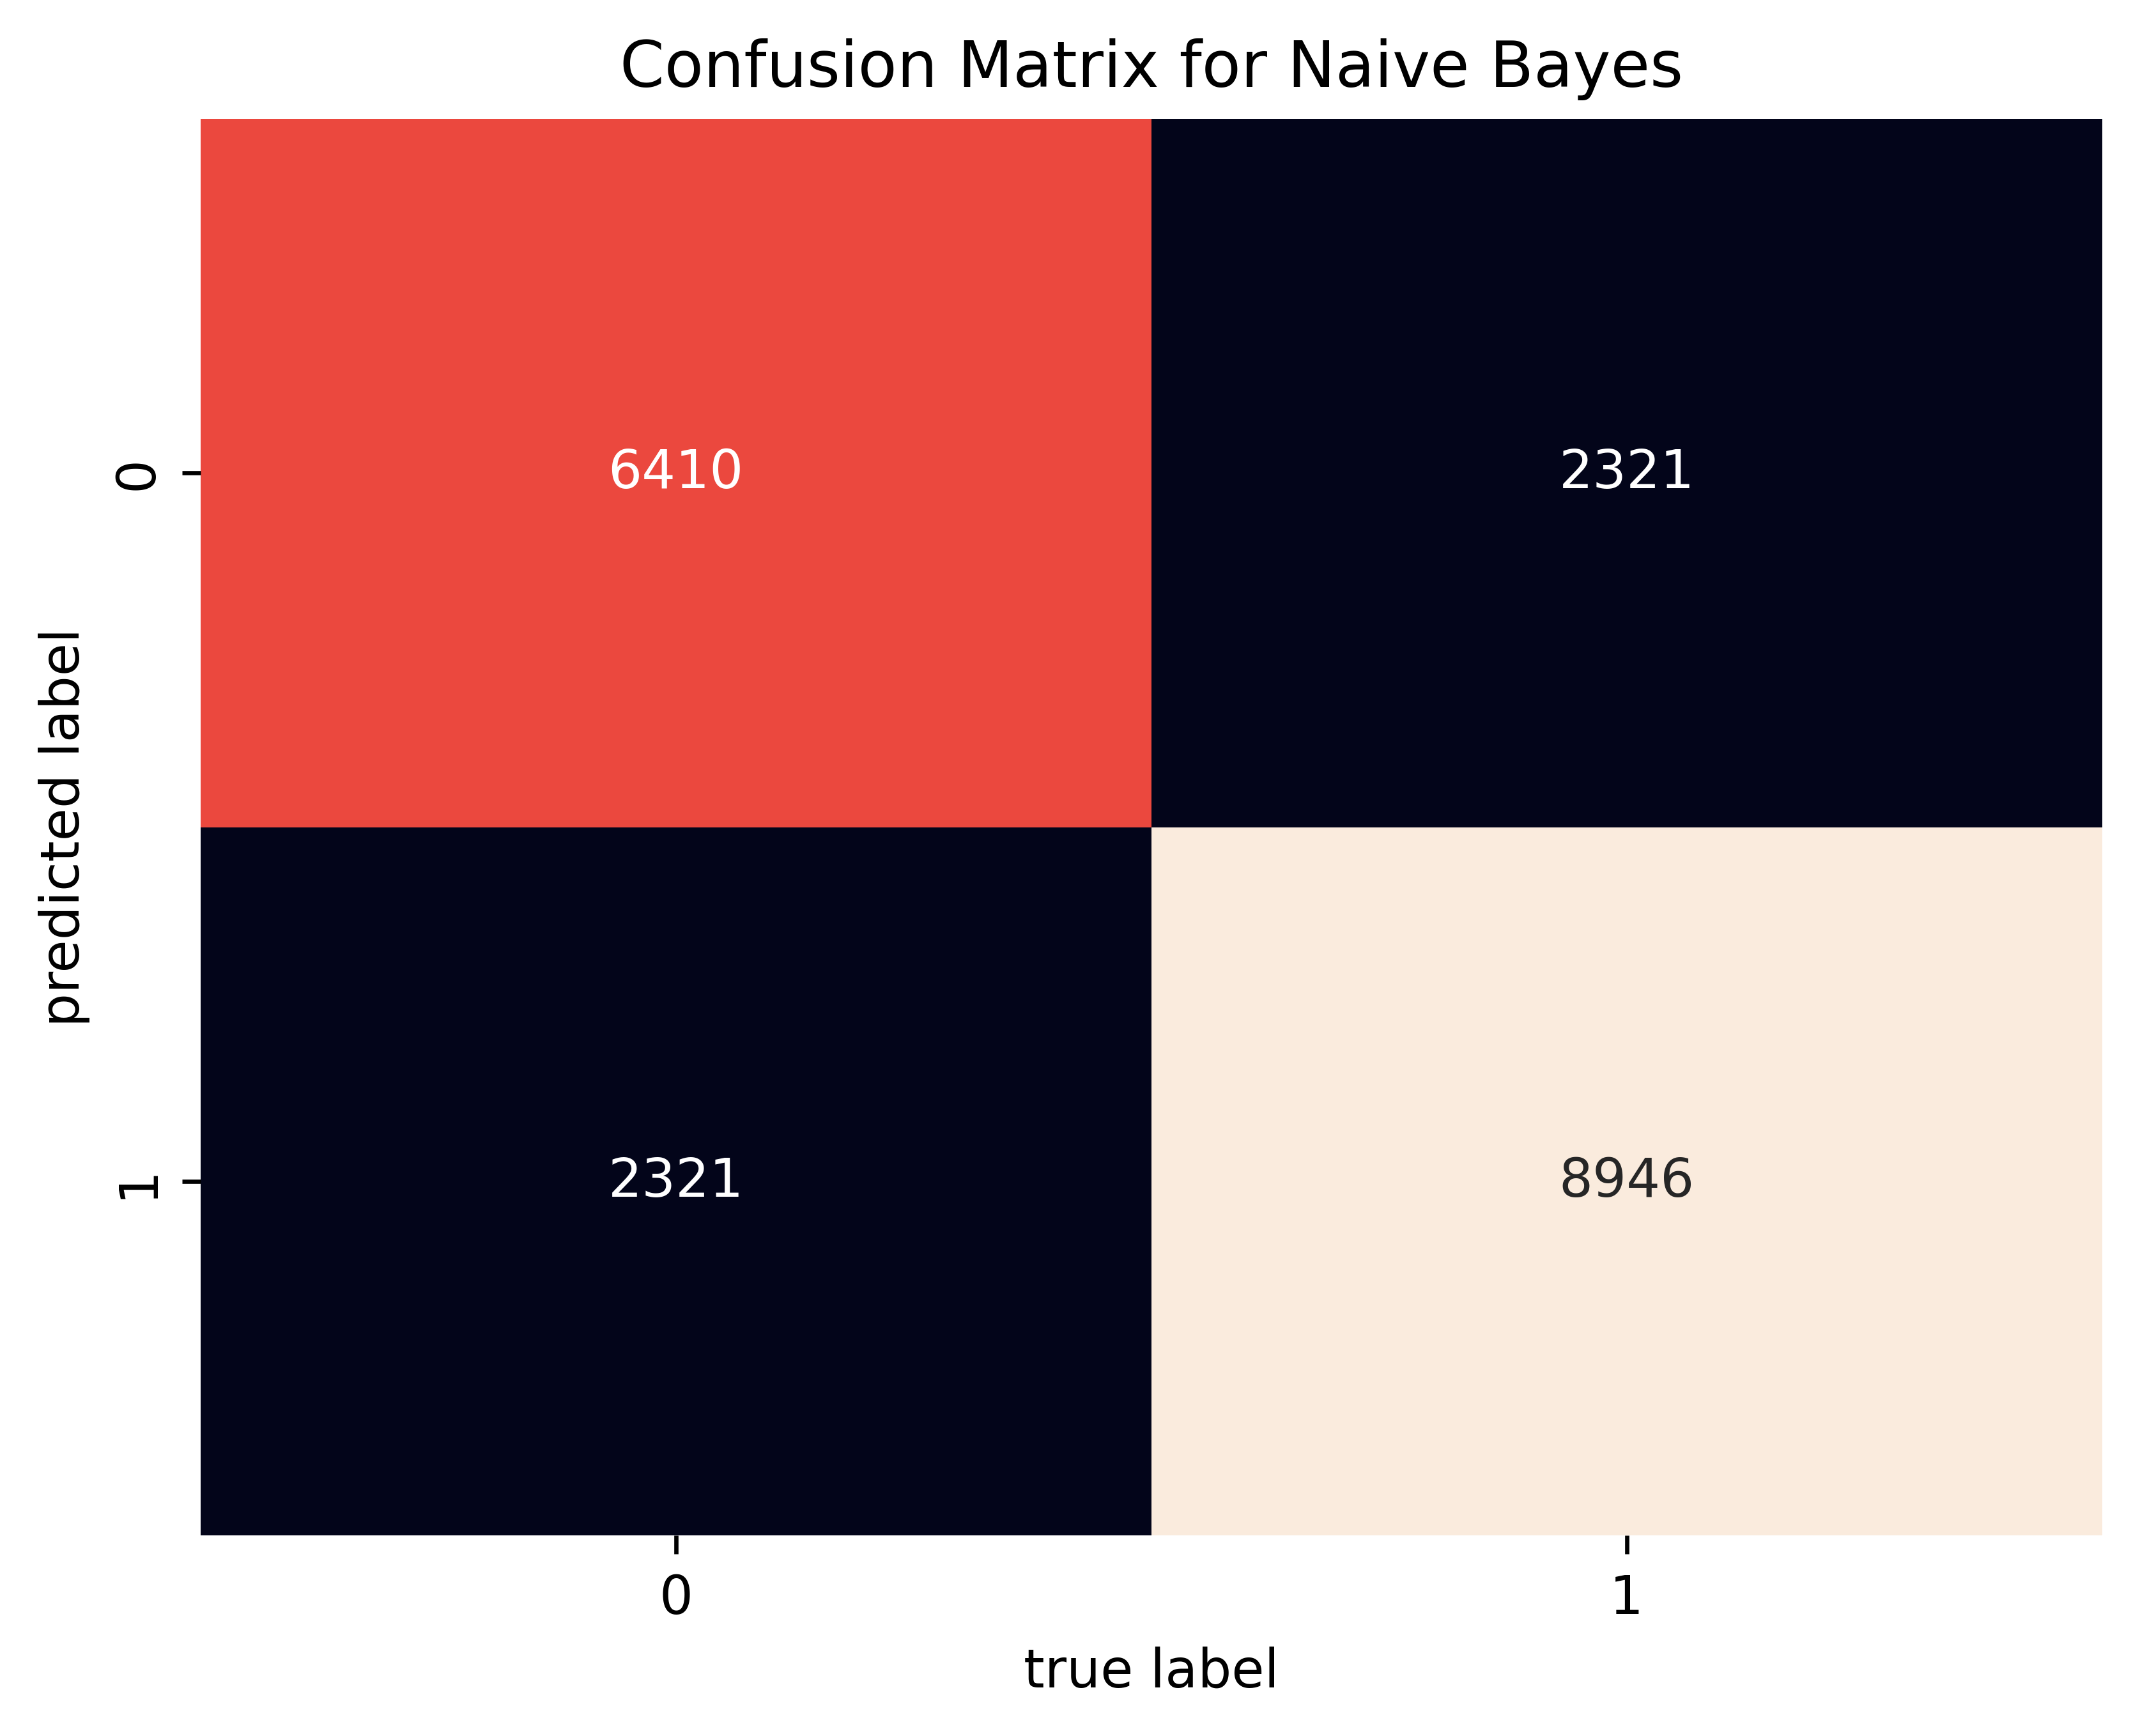

In [27]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=600)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Find out accuracy of our prediction

In [28]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)

Accuracy with Naive-bayes:  0.7678767876787679


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8731
           1       0.79      0.79      0.79     11267

    accuracy                           0.77     19998
   macro avg       0.76      0.76      0.76     19998
weighted avg       0.77      0.77      0.77     19998



### Drawing ROC curve

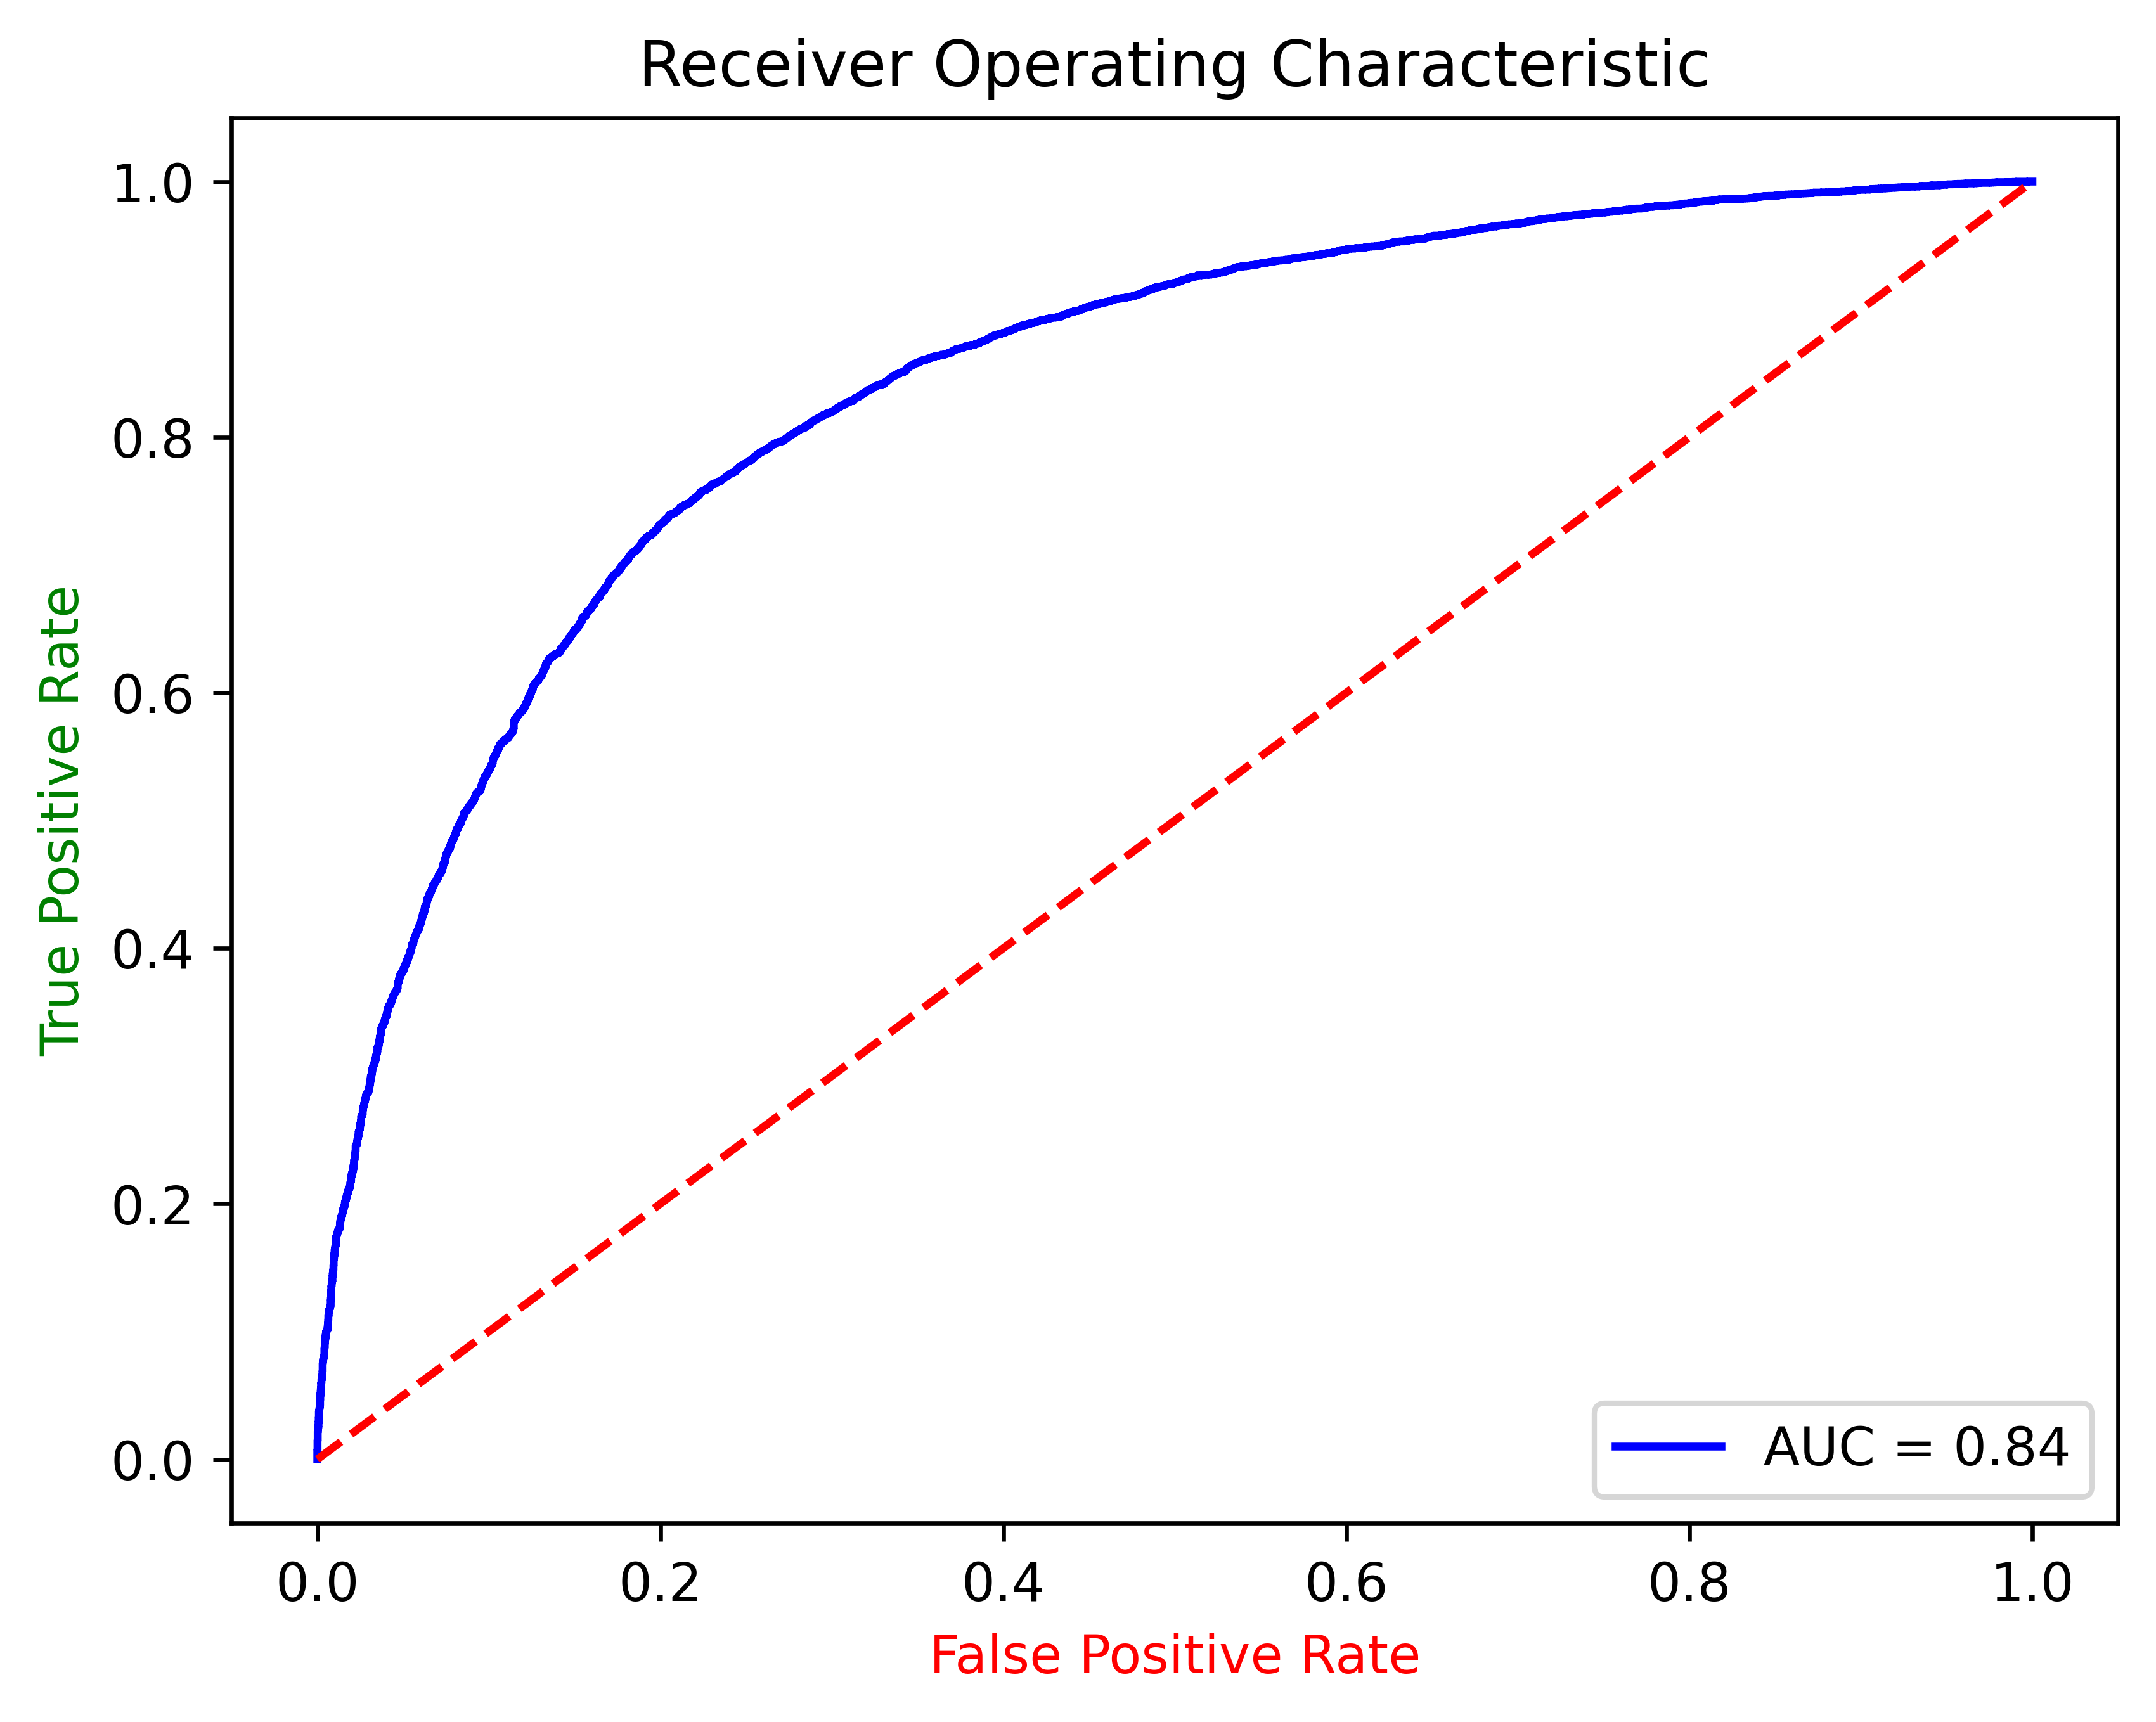

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=600)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()